<a class="anchor" id="top"></a>

** **

# 1. Importing Libraries & Data
In this section, we set up the foundation for our project by importing the necessary Python libraries and loading the dataset. These libraries provide the tools for data manipulation, visualization, and machine learning modeling throughout the notebook. Additionally, we import the historical claims dataset, which forms the core of our analysis. 

In [14]:
import pandas as pd
import numpy as np

# Train-Test Split
from sklearn.model_selection import train_test_split

import preproc as p

# fs
from sklearn.feature_selection import VarianceThreshold
import feature_selection as fs

pd.set_option('display.max_columns', None)
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

**Import Data**

In [24]:
# Load training data
df = pd.read_csv('./project_data/train_data.csv', index_col = 'Claim Identifier')

# Load testing data
test = pd.read_csv('./project_data/test_data.csv', index_col = 'Claim Identifier')

# Display the first 3 rows of the training data
df.head(3)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393875,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
5393091,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
5393889,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0


# 2. Train-Test Split
The train-test split is a crucial technique used to assess model performance by dividing the dataset into training and testing subsets. This ensures that the model is evaluated on unseen data, helping to prevent overfitting and providing an unbiased performance estimate. 

<a href="#top">Top &#129033;</a>

**Holdout Method**

In [25]:
# Split the DataFrame into features (X) and target variable (y)
X = df.drop('Claim Injury Type', axis=1)
y = df['Claim Injury Type']

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y) 

# 3. Missing Values

<a href="#top">Top &#129033;</a>

In [ ]:
X_train.isna().sum()

**Birth Year**

To fill the missing values, we will start by creating a mask, which filters for observations where **Age at Injury** and **Accident Date Year** are not missing, and when **Birth Year** is either missing or zero. Since we are going to use **Age at Injury** and **Accident Date Year** to compute **Birth Year**, ensuring those two variables are no missing is crucial. Then, we also decided to recompute the **Birth Year** where it is 0, since it is impossible to have 0 as a **Birth Year**.

In [ ]:
train_mask = X_train['Accident Date Year'].notna() & X_train['Age at Injury'].notna() & \
           (X_train['Birth Year'].isna() | (X_train['Birth Year'] == 0))


val_mask = (X_val['Accident Date Year'].notna() &  X_val['Age at Injury'].notna() &  
    (X_val['Birth Year'].isna() | (X_val['Birth Year'] == 0)))

test_mask = test['Accident Date Year'].notna() & test['Age at Injury'].notna() & \
           (test['Birth Year'].isna() | (test['Birth Year'] == 0))

In [ ]:
X_train.loc[train_mask, 'Birth Year'] = X_train['Accident Date Year'] - X_train['Age at Injury']

X_val.loc[val_mask, 'Birth Year'] = X_val['Accident Date Year'] - X_val['Age at Injury']

test.loc[test_mask, 'Birth Year'] = test['Accident Date Year'] - test['Age at Injury']

**Average Weekly Wage**

In [ ]:
X_train['Average Weekly Wage'] = p.ball_tree_impute(X_train, 'Average Weekly Wage', n_neighbors=100)

X_val['Average Weekly Wage'] = p.ball_tree_impute(X_val, 'Average Weekly Wage', n_neighbors=100)

test['Average Weekly Wage'] = p.ball_tree_impute(test, 'Average Weekly Wage', n_neighbors=100)

# 3. Outliers

<a href="#top">Top &#129033;</a>

### Outlier Detection

To detect outliers we will use a function that plots boxplots and identifies outliers based on the Interquartile Range method. This function will also add to a list all columns with a higher percentage of outliers than a previously set threshold.

Column: Age at Injury - Number of Outliers: 0
Column: Age at Injury - % of Outliers: 0.00% 



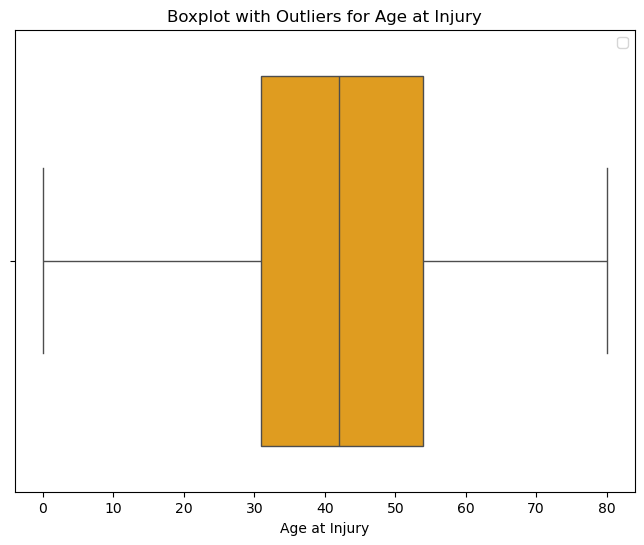

Column: Average Weekly Wage - Number of Outliers: 18431
Column: Average Weekly Wage - % of Outliers: 4.16% 



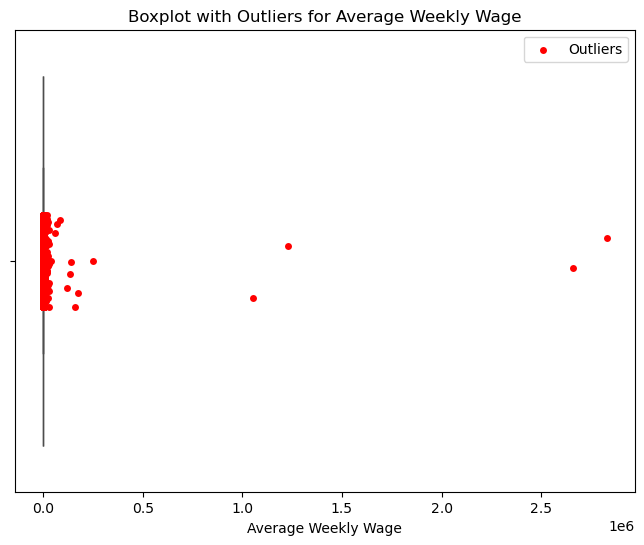

Column: Birth Year - Number of Outliers: 103
Column: Birth Year - % of Outliers: 0.02% 



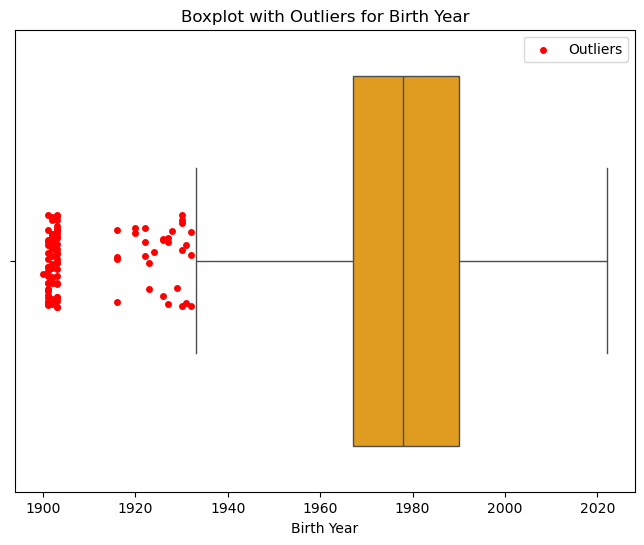

Column: IME-4 Count - Number of Outliers: 103518
Column: IME-4 Count - % of Outliers: 23.37% 



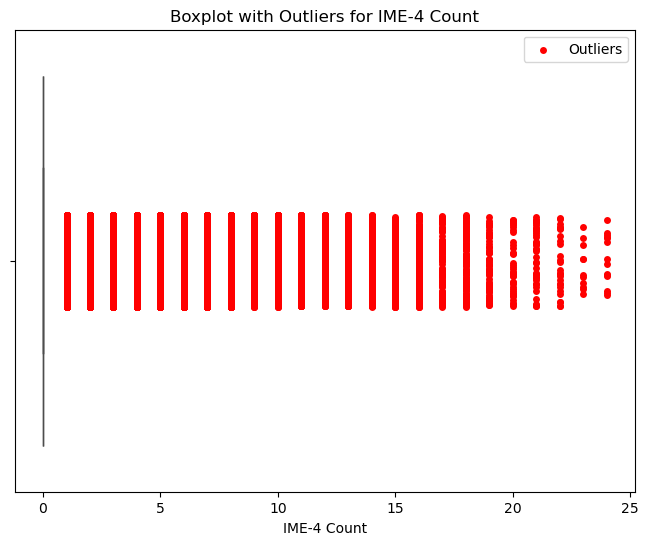

Column: Industry Code - Number of Outliers: 81447
Column: Industry Code - % of Outliers: 18.39% 



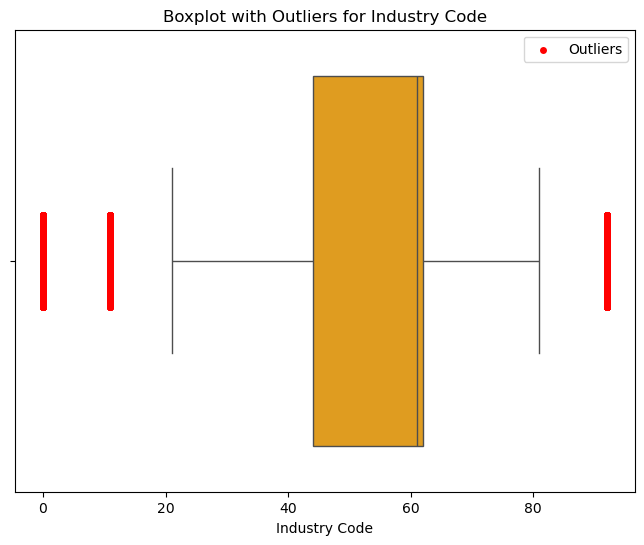

Column: WCIO Cause of Injury Code - Number of Outliers: 0
Column: WCIO Cause of Injury Code - % of Outliers: 0.00% 



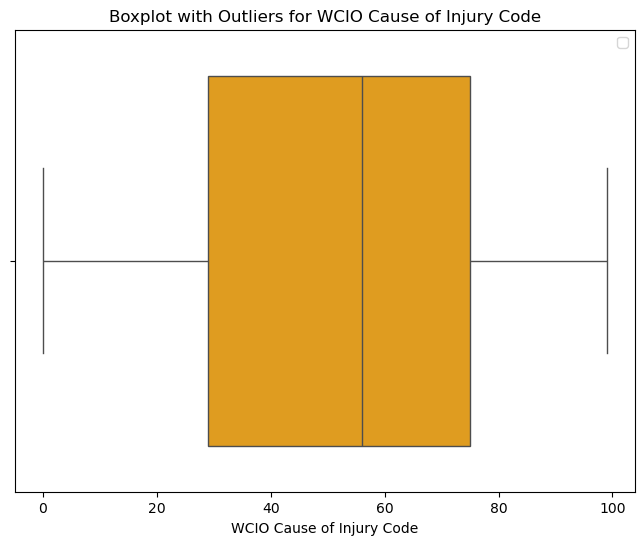

Column: WCIO Nature of Injury Code - Number of Outliers: 0
Column: WCIO Nature of Injury Code - % of Outliers: 0.00% 



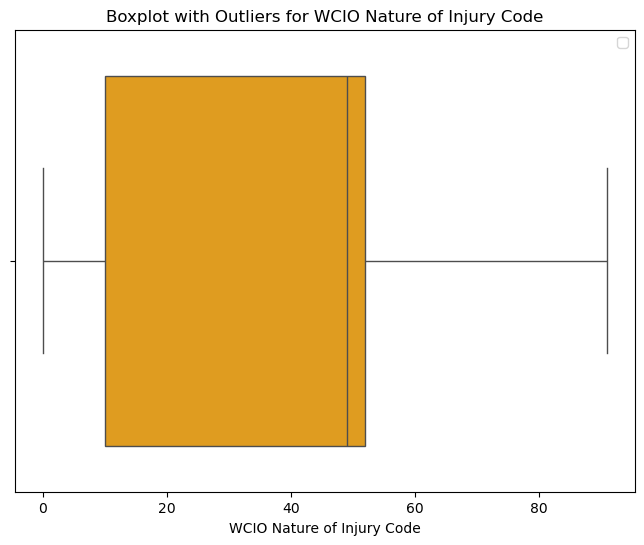

Column: WCIO Part Of Body Code - Number of Outliers: 39298
Column: WCIO Part Of Body Code - % of Outliers: 8.87% 



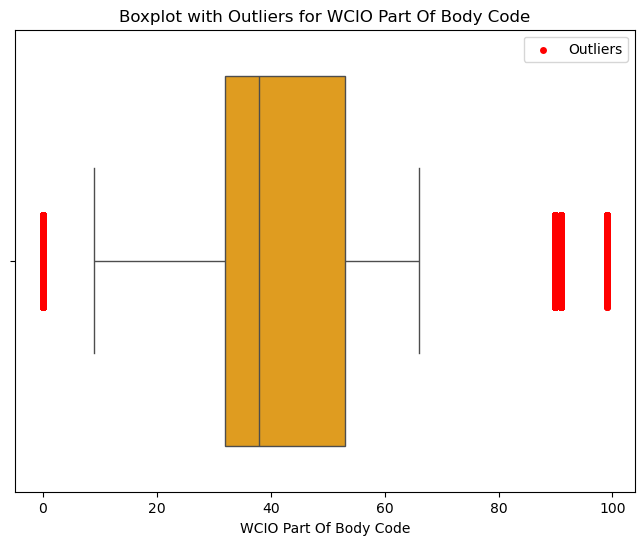

Column: Number of Dependents - Number of Outliers: 0
Column: Number of Dependents - % of Outliers: 0.00% 



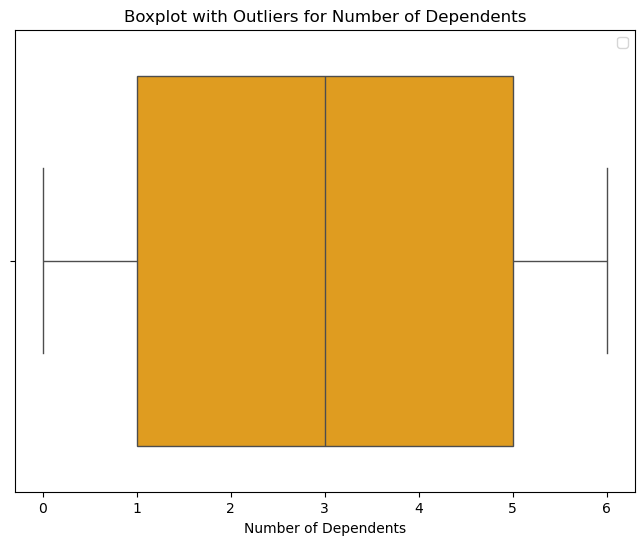

Column: Alternative Dispute Resolution Bin - Number of Outliers: 1945
Column: Alternative Dispute Resolution Bin - % of Outliers: 0.44% 



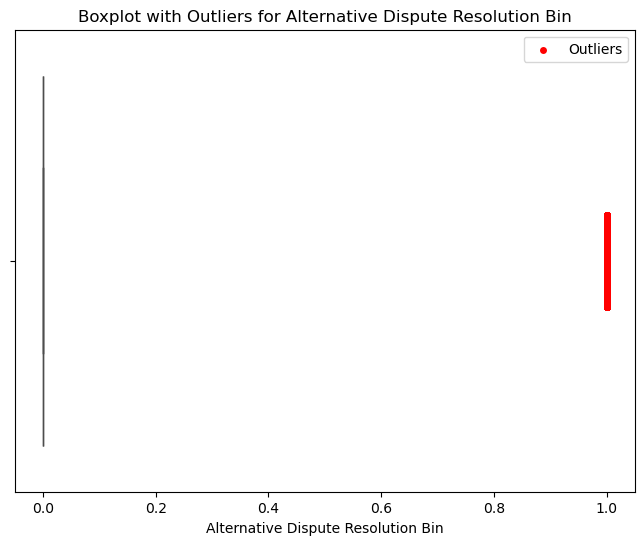

Column: Attorney/Representative Bin - Number of Outliers: 0
Column: Attorney/Representative Bin - % of Outliers: 0.00% 



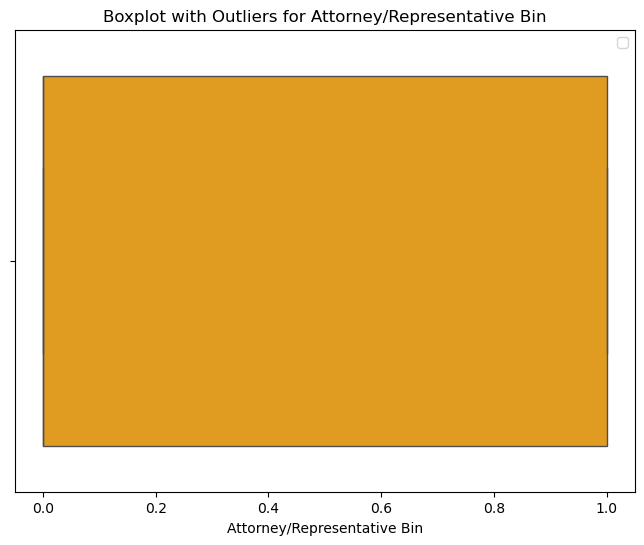

Column: Carrier Name Enc - Number of Outliers: 0
Column: Carrier Name Enc - % of Outliers: 0.00% 



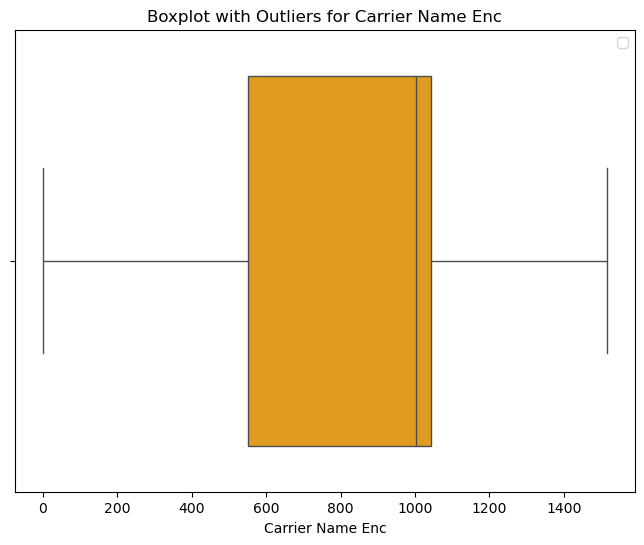

Column: Carrier Type freq - Number of Outliers: 0
Column: Carrier Type freq - % of Outliers: 0.00% 



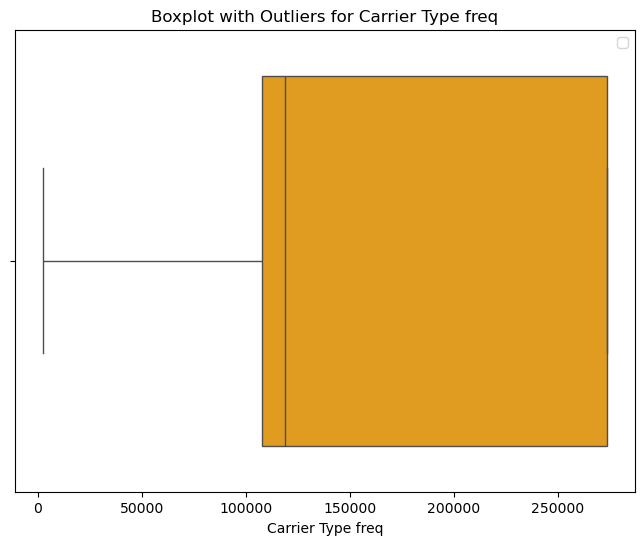

Column: Carrier Type_1A. PRIVATE - Number of Outliers: 0
Column: Carrier Type_1A. PRIVATE - % of Outliers: 0.00% 



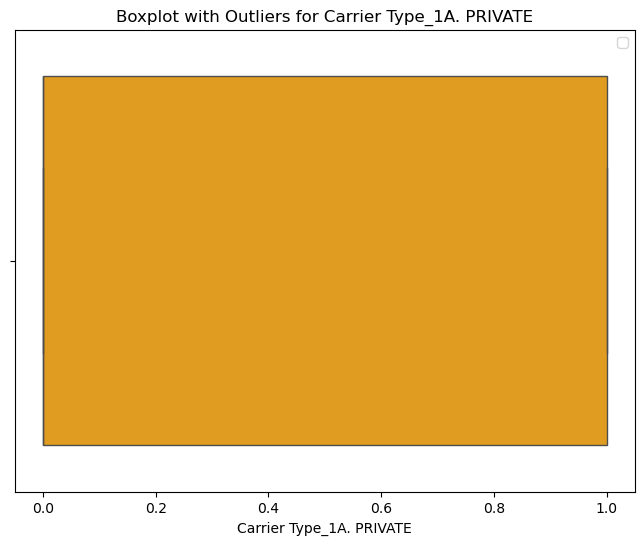

Column: Carrier Type_2A. SIF - Number of Outliers: 86030
Column: Carrier Type_2A. SIF - % of Outliers: 19.42% 



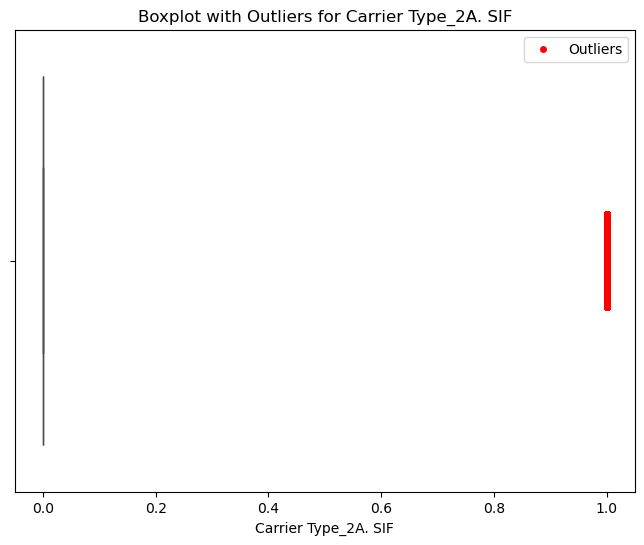

Column: Carrier Type_3A. SELF PUBLIC - Number of Outliers: 95183
Column: Carrier Type_3A. SELF PUBLIC - % of Outliers: 21.49% 



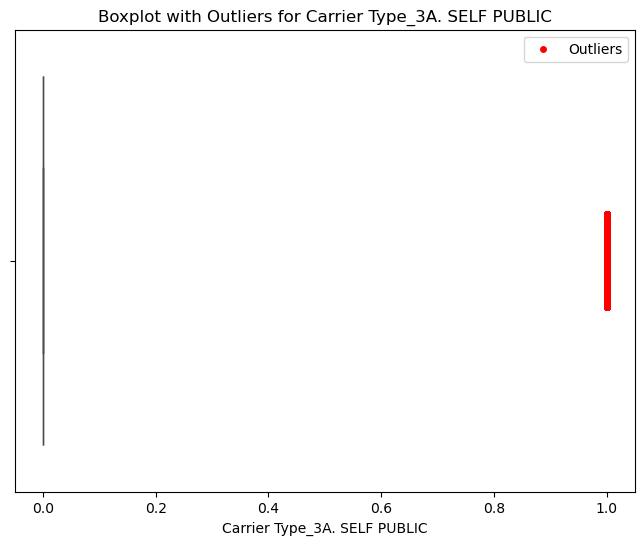

Column: Carrier Type_4A. SELF PRIVATE - Number of Outliers: 40840
Column: Carrier Type_4A. SELF PRIVATE - % of Outliers: 9.22% 



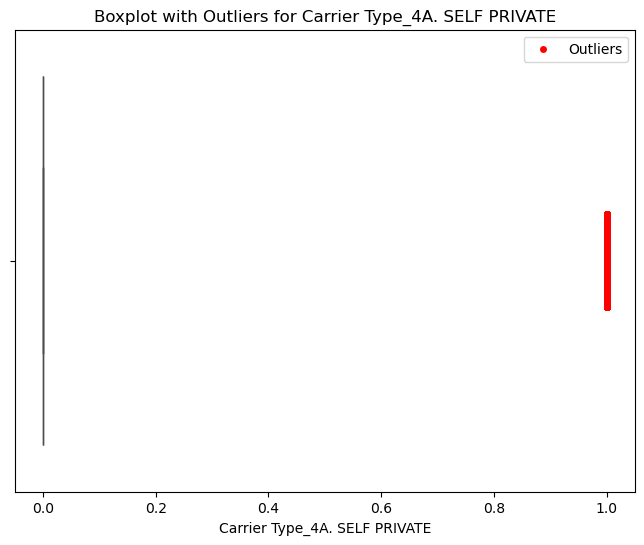

Column: County of Injury freq - Number of Outliers: 0
Column: County of Injury freq - % of Outliers: 0.00% 



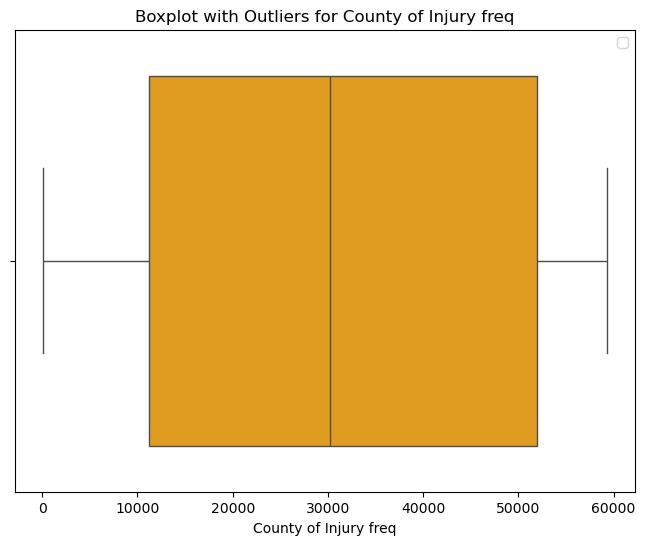

Column: COVID-19 Indicator Enc - Number of Outliers: 21038
Column: COVID-19 Indicator Enc - % of Outliers: 4.75% 



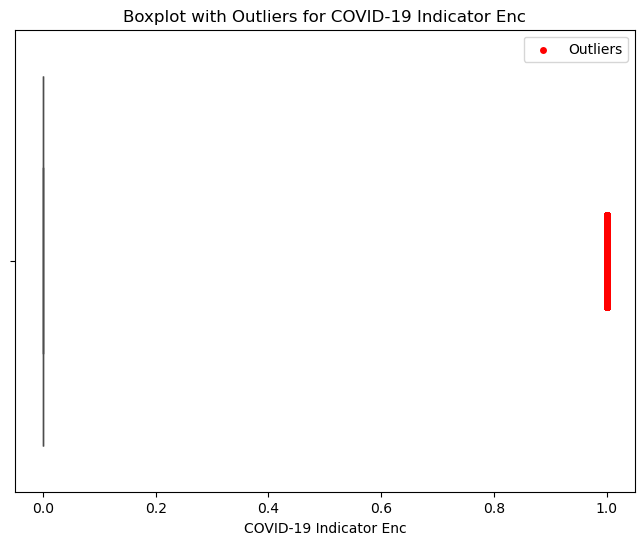

Column: District Name freq - Number of Outliers: 0
Column: District Name freq - % of Outliers: 0.00% 



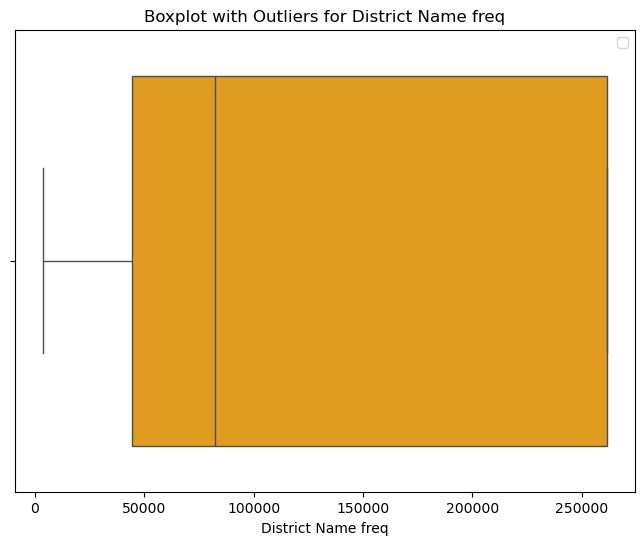

Column: Gender Enc - Number of Outliers: 0
Column: Gender Enc - % of Outliers: 0.00% 



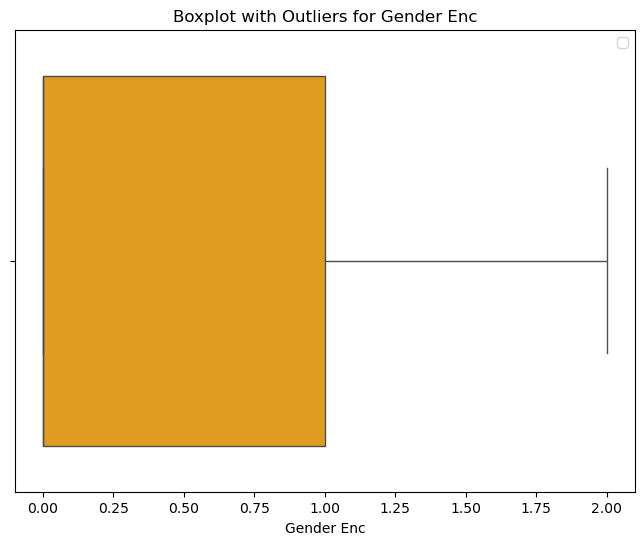

Column: Gender_F - Number of Outliers: 0
Column: Gender_F - % of Outliers: 0.00% 



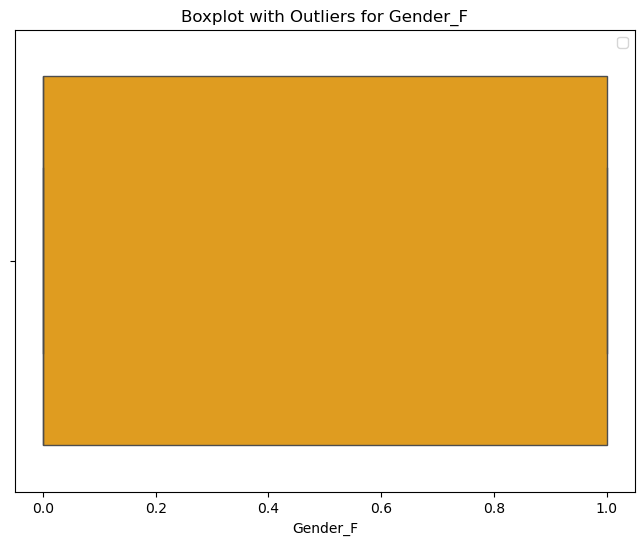

Column: Gender_M - Number of Outliers: 0
Column: Gender_M - % of Outliers: 0.00% 



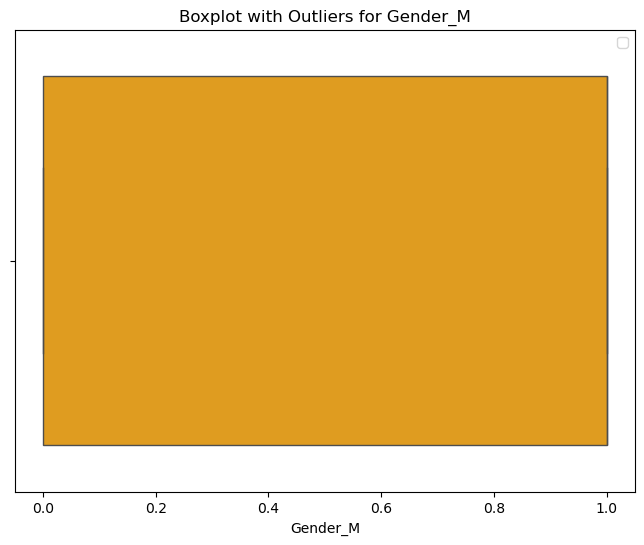

Column: Medical Fee Region freq - Number of Outliers: 0
Column: Medical Fee Region freq - % of Outliers: 0.00% 



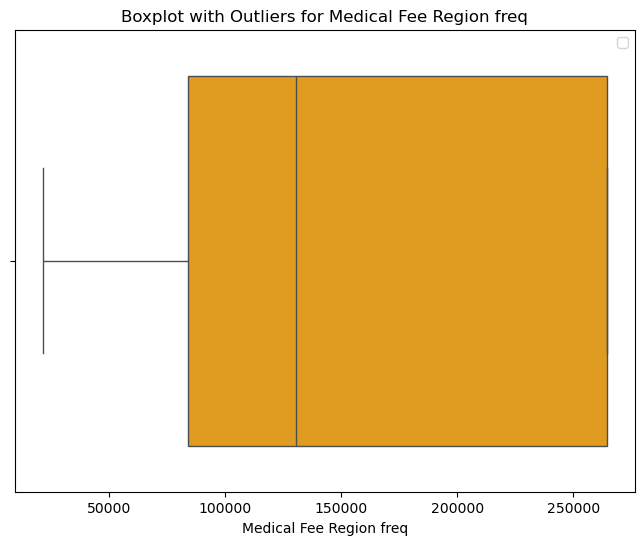

Column: Accident Date Year - Number of Outliers: 3494
Column: Accident Date Year - % of Outliers: 0.79% 



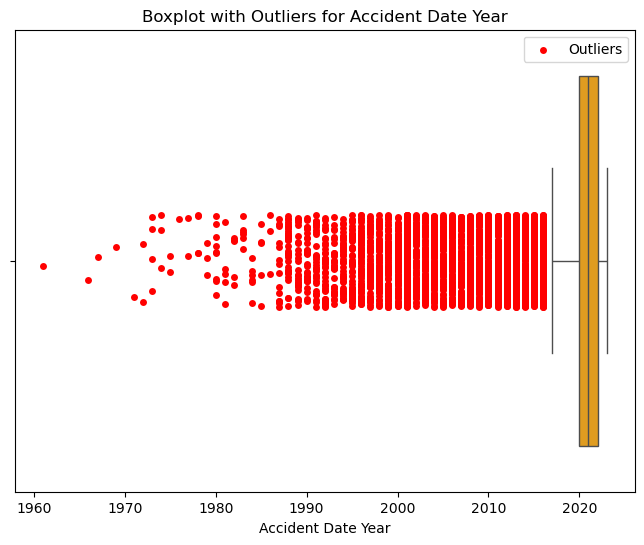

Column: Accident Date Month - Number of Outliers: 0
Column: Accident Date Month - % of Outliers: 0.00% 



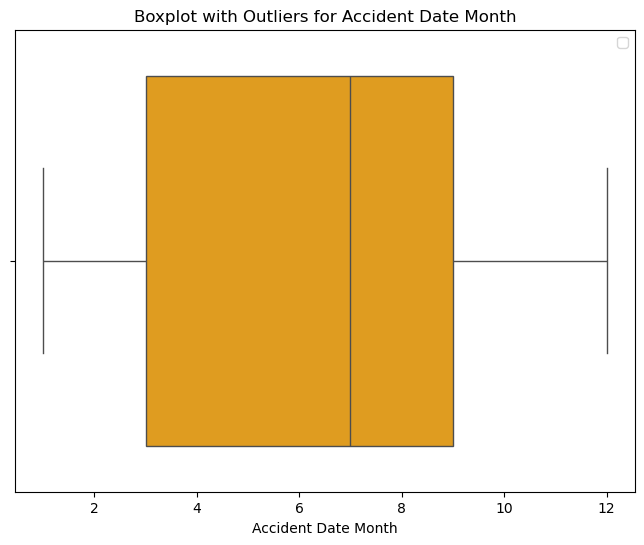

Column: Accident Date Day - Number of Outliers: 0
Column: Accident Date Day - % of Outliers: 0.00% 



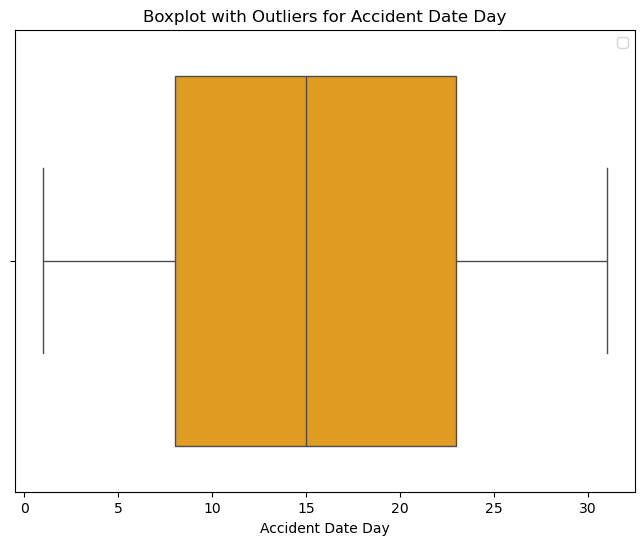

Column: Accident Date Day of Week - Number of Outliers: 0
Column: Accident Date Day of Week - % of Outliers: 0.00% 



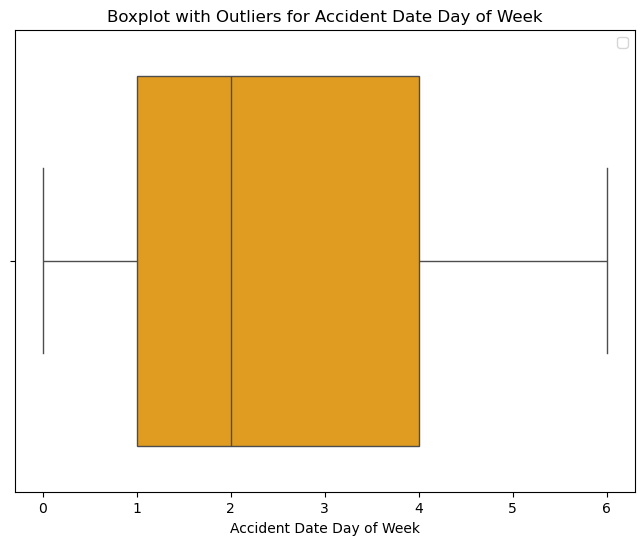

Column: Assembly Date Year - Number of Outliers: 0
Column: Assembly Date Year - % of Outliers: 0.00% 



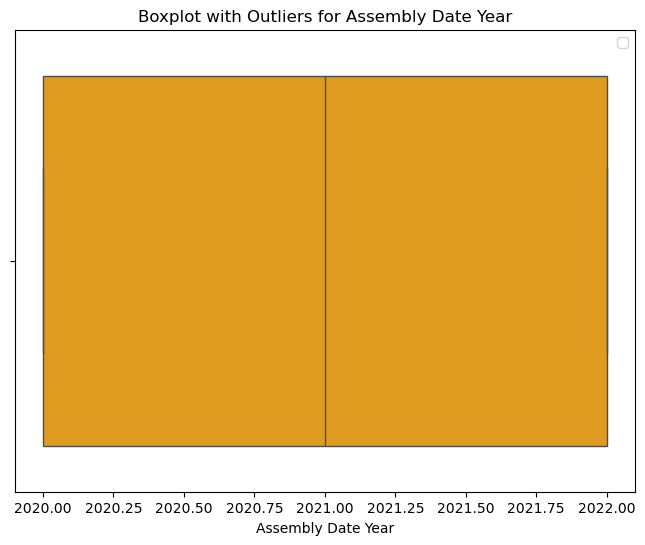

Column: Assembly Date Month - Number of Outliers: 0
Column: Assembly Date Month - % of Outliers: 0.00% 



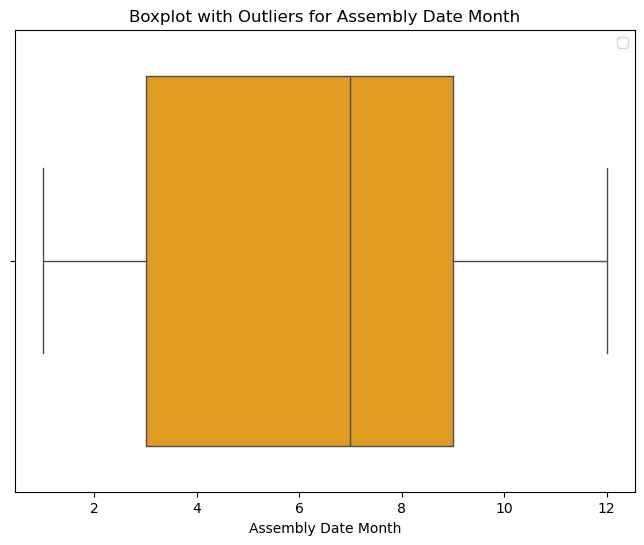

Column: Assembly Date Day - Number of Outliers: 0
Column: Assembly Date Day - % of Outliers: 0.00% 



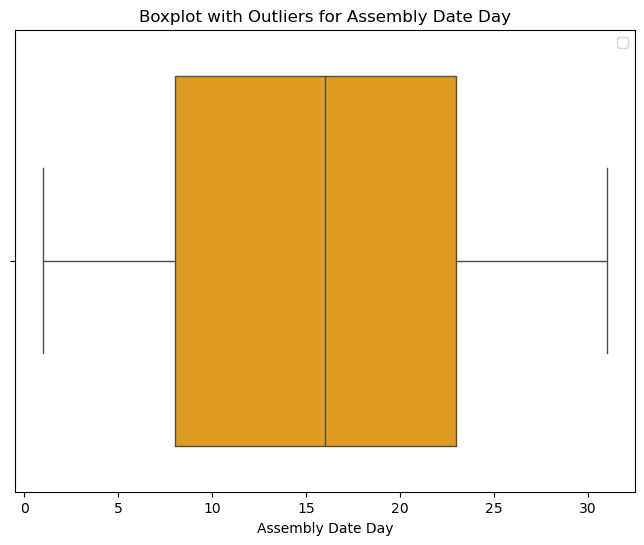

Column: Assembly Date Day of Week - Number of Outliers: 0
Column: Assembly Date Day of Week - % of Outliers: 0.00% 



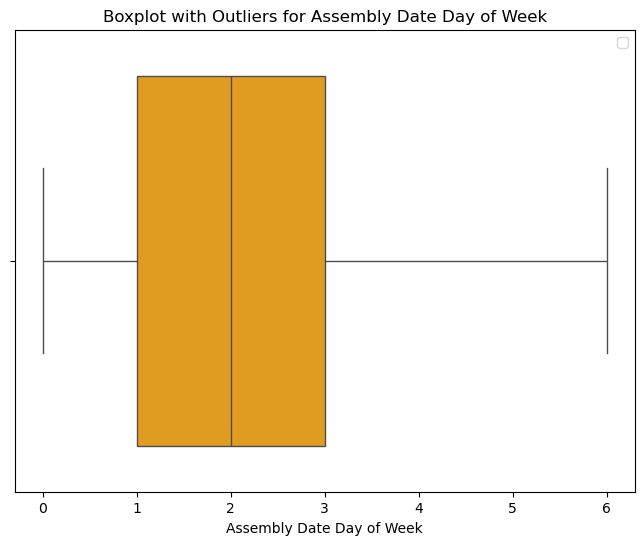

Column: C-2 Date Year - Number of Outliers: 883
Column: C-2 Date Year - % of Outliers: 0.20% 



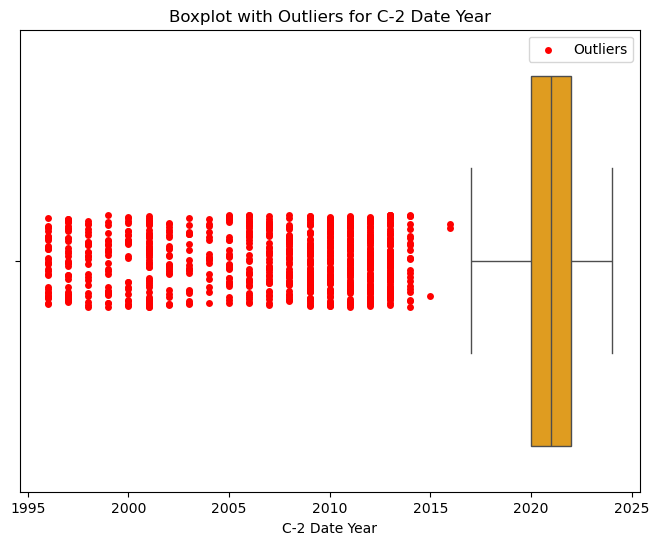

Column: C-2 Date Month - Number of Outliers: 0
Column: C-2 Date Month - % of Outliers: 0.00% 



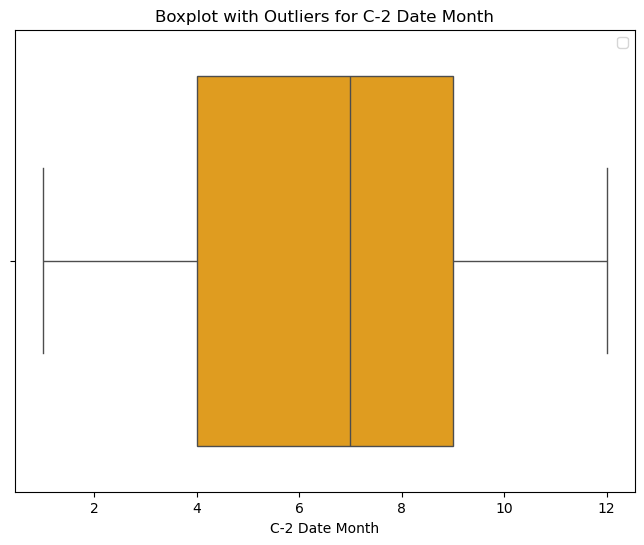

Column: C-2 Date Day - Number of Outliers: 0
Column: C-2 Date Day - % of Outliers: 0.00% 



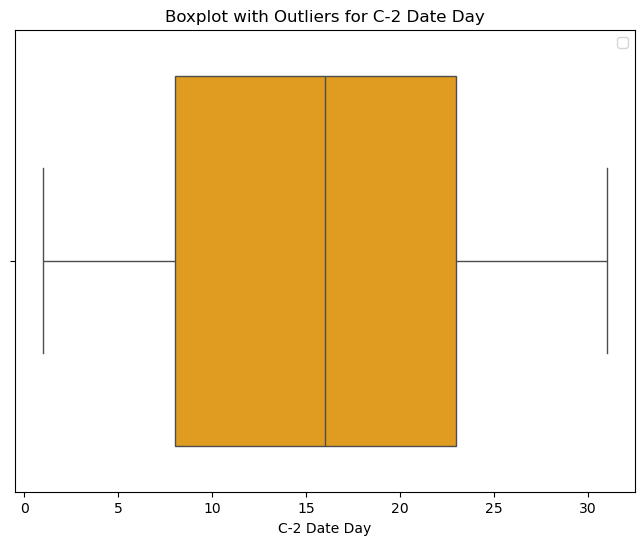

Column: C-2 Date Day of Week - Number of Outliers: 0
Column: C-2 Date Day of Week - % of Outliers: 0.00% 



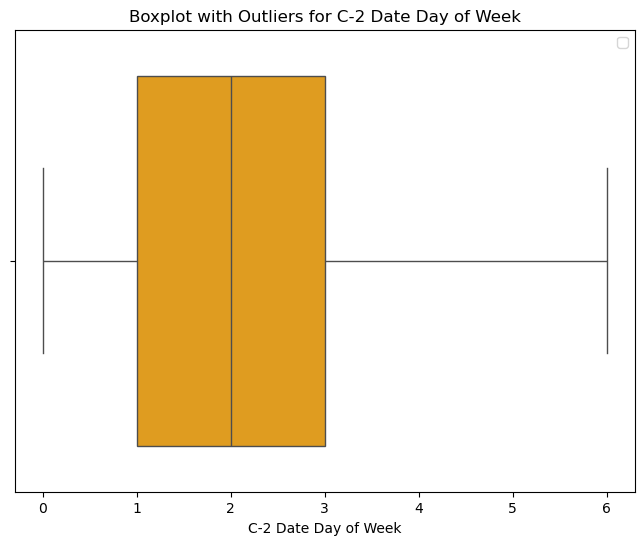

Column: WCIO Codes - Number of Outliers: 0
Column: WCIO Codes - % of Outliers: 0.00% 



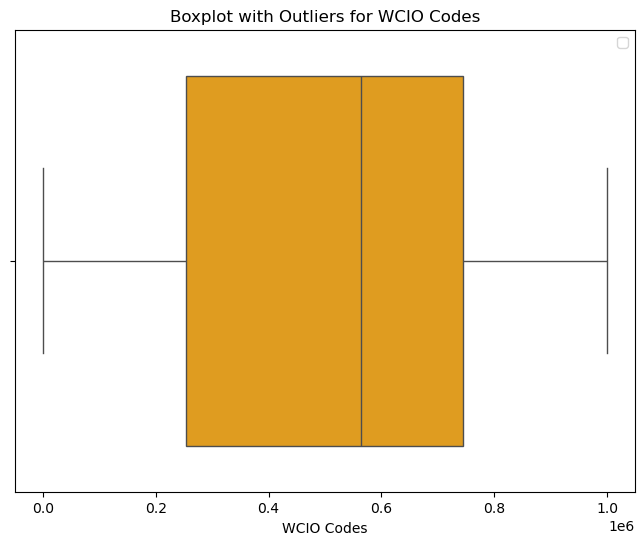

Column: Zip Code Valid - Number of Outliers: 33907
Column: Zip Code Valid - % of Outliers: 7.66% 



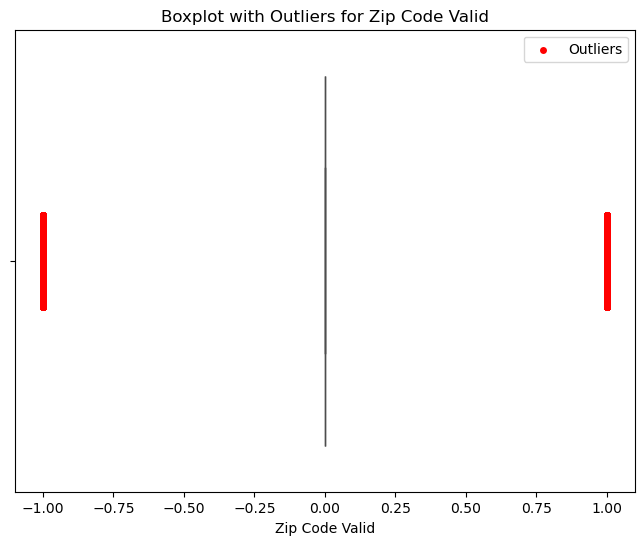

Column: Industry Sector Count Enc - Number of Outliers: 0
Column: Industry Sector Count Enc - % of Outliers: 0.00% 



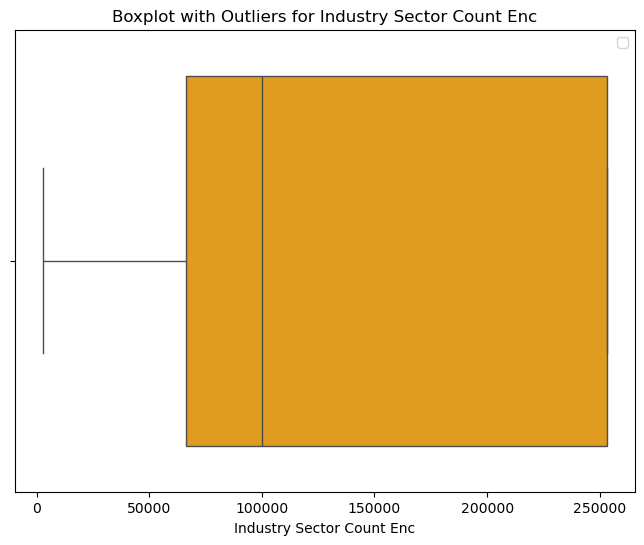

Column: Age Group - Number of Outliers: 23820
Column: Age Group - % of Outliers: 5.38% 



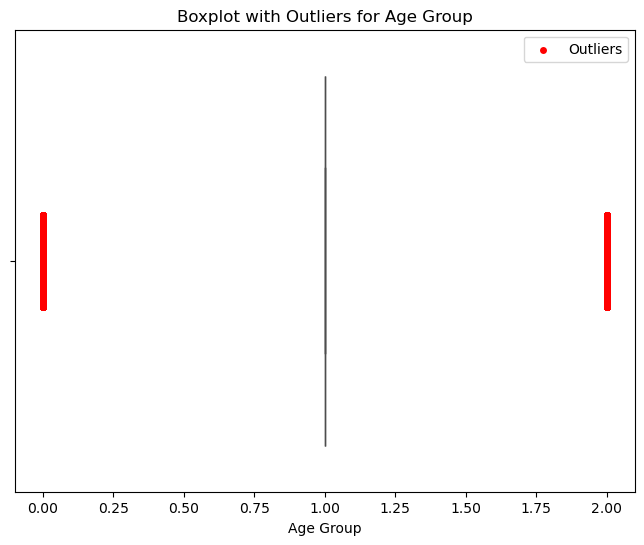

Column: C-3 Date Binary - Number of Outliers: 0
Column: C-3 Date Binary - % of Outliers: 0.00% 



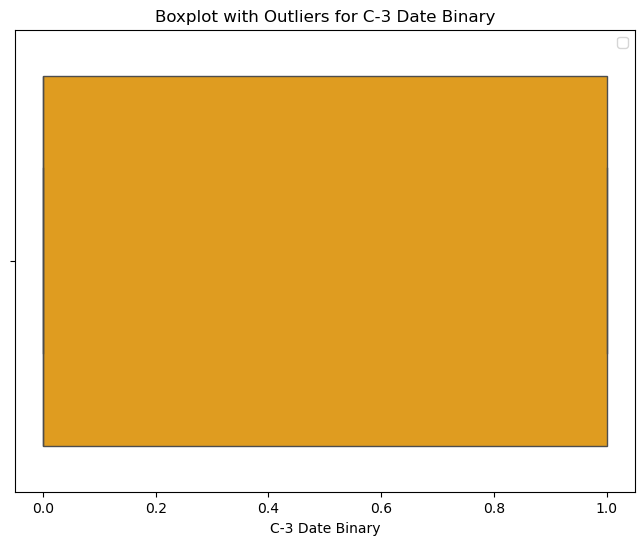

Column: First Hearing Date Binary - Number of Outliers: 0
Column: First Hearing Date Binary - % of Outliers: 0.00% 



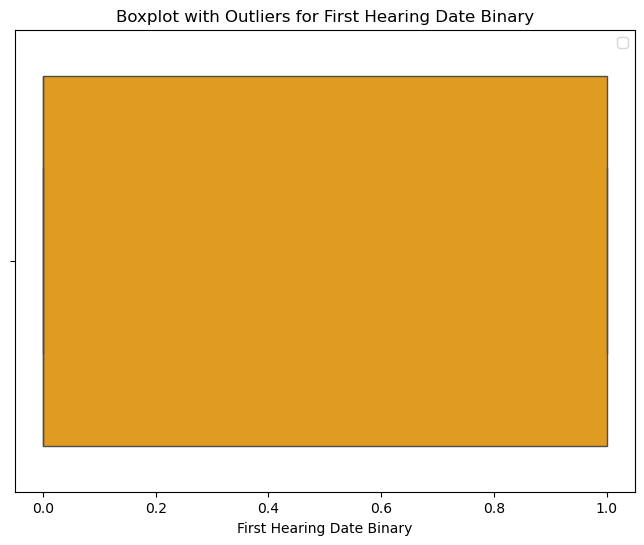

Columns with more than 0.0001% Outliers:
['Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Industry Code', 'WCIO Part Of Body Code', 'Alternative Dispute Resolution Bin', 'Carrier Type_2A. SIF', 'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc', 'Accident Date Year', 'C-2 Date Year', 'Zip Code Valid', 'Age Group']


{'Age at Injury': {'lower_bound': -3.5, 'upper_bound': 88.5},
 'Average Weekly Wage': {'lower_bound': -1240.24875,
  'upper_bound': 2067.08125},
 'Birth Year': {'lower_bound': 1932.5, 'upper_bound': 2024.5},
 'IME-4 Count': {'lower_bound': 0.0, 'upper_bound': 0.0},
 'Industry Code': {'lower_bound': 17.0, 'upper_bound': 89.0},
 'WCIO Cause of Injury Code': {'lower_bound': -40.0, 'upper_bound': 144.0},
 'WCIO Nature of Injury Code': {'lower_bound': -53.0, 'upper_bound': 115.0},
 'WCIO Part Of Body Code': {'lower_bound': 0.5, 'upper_bound': 84.5},
 'Number of Dependents': {'lower_bound': -5.0, 'upper_bound': 11.0},
 'Alternative Dispute Resolution Bin': {'lower_bound': 0.0,
  'upper_bound': 0.0},
 'Attorney/Representative Bin': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carrier Name Enc': {'lower_bound': -189.5, 'upper_bound': 1782.5},
 'Carrier Type freq': {'lower_bound': -140960.5, 'upper_bound': 522051.5},
 'Carrier Type_1A. PRIVATE': {'lower_bound': -1.5, 'upper_bound': 2.5},
 'Carr

In [ ]:
p.detect_outliers_iqr(X_train, 0.0001)

### Dealing With Outliers

Here we will apply some techniques to attempt to deal with outliers, either by applying some transformations or removing them. Our goal is to not remove more than 5% of observations. To keep track of this metrics, we will start by saving the initial length of the dataset.

In [ ]:
X_train_copy = X_train.copy()
X_train_len = len(X_train_copy)

**Average Weekly Wage**

In [ ]:
dropped_len_wage = len(X_train[X_train['Average Weekly Wage'] > 7300])

X_train = X_train[X_train['Average Weekly Wage'] <= 7300]

**Birth Year**

In [ ]:
dropped_len_birth_year = len(X_train[X_train['Birth Year'] < 1932.5])

X_train = X_train[X_train['Birth Year'] > 1932.5]

**IME-4 Count**

In [ ]:
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])
X_train['IME-4 Count Double Log'] = np.log1p(X_train['IME-4 Count Log'])

**Alternative Dispute Resolution Bin**

In [ ]:
dropped_len_alt_disp = len(X_train[X_train['Alternative Dispute Resolution Bin'] == 1])

X_train = X_train[X_train['Alternative Dispute Resolution Bin'] == 0]

**Covid-19 Indicator Enc**

In [ ]:
X_train[X_train['COVID-19 Indicator Enc'] == 1]

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary,IME-4 Count Log,IME-4 Count Double Log
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5640931,65.0,0.00,1955.0,0.0,62.0,83,83,99,2.0,0,0,1495,273422,1,0,0,0,13222,1,82516,2,0,0,130727,2021,1,4,0.0,2021,1,21,3,2021,1,21,3.0,838399,0,253064,2,0,0,0.0,0.0
5480670,35.0,0.00,1985.0,0.0,62.0,83,83,60,3.0,0,1,339,273422,1,0,0,0,27071,1,261405,1,1,0,21621,2020,3,8,6.0,2020,5,12,1,2020,5,11,0.0,838360,0,253064,1,0,1,0.0,0.0
5877838,57.0,0.00,1964.0,0.0,92.0,83,83,91,2.0,0,0,461,118955,0,0,1,0,59279,1,59382,1,1,0,264398,2021,11,9,1.0,2021,12,14,1,2021,12,14,1.0,838391,0,253064,1,0,0,0.0,0.0
5791871,42.0,0.00,1978.0,0.0,92.0,83,83,91,3.0,0,0,461,118955,0,0,1,0,59279,1,59382,0,0,1,264398,2021,8,9,0.0,2021,8,18,2,2021,8,18,2.0,838391,0,253064,1,0,0,0.0,0.0
5618799,29.0,1499.86,1990.0,0.0,62.0,83,83,60,4.0,0,0,1303,51080,0,0,0,1,30192,1,44307,1,1,0,130727,2020,11,5,3.0,2020,12,15,1,2020,12,15,1.0,838360,0,253064,1,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820967,32.0,0.00,1988.0,0.0,92.0,83,83,60,2.0,0,0,1041,107669,0,1,0,0,2336,1,82516,0,0,1,84173,2021,9,17,4.0,2021,9,27,0,2021,9,27,0.0,838360,0,253064,1,0,0,0.0,0.0
5943011,27.0,0.00,1994.0,0.0,62.0,83,83,91,0.0,0,0,339,273422,1,0,0,0,56708,1,261405,2,0,0,264398,2021,12,30,3.0,2022,3,14,0,2022,3,14,0.0,838391,0,253064,1,0,0,0.0,0.0
5459803,28.0,0.00,1991.0,0.0,44.0,83,83,66,2.0,0,0,328,273422,1,0,0,0,51991,1,261405,0,0,1,264398,2020,3,19,3.0,2020,3,27,4,2020,3,27,4.0,838366,-1,99969,1,0,0,0.0,0.0


**Accident Date Year**

In [ ]:
dropped_len_accident_year =len(X_train[X_train['Accident Date Year'] < 2017])

X_train = X_train[X_train['Accident Date Year'] >= 2017]

**C-2 Date Year**

In [ ]:
dropped_len_c2_year =len(X_train[X_train['C-2 Date Year'] < 2017])

X_train = X_train[X_train['C-2 Date Year'] >= 2017]

**Assess Decisions**

Since we dropped less than 5% of observations, we can continue to feature selection

In [ ]:
len_dropped = dropped_len_wage + dropped_len_birth_year + dropped_len_alt_disp + dropped_len_accident_year + dropped_len_c2_year 

len_dropped / X_train_len

0.01269732326698696

Ensure y_train has the same indices as X_train

In [ ]:
common_indices = y_train.intersection(X_train.index)
y_train = y_train.intersection(common_indices)

Winsorization for 'Average Weekly Wage'

In [ ]:
upper_limit = X_train['Average Weekly Wage'].quantile(0.99)
lower_limit = X_train['Average Weekly Wage'].quantile(0.01)
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(lower=lower_limit, upper=upper_limit)

Transformations

In [ ]:
# Log transformation for 'IME-4 Count'
X_train['IME-4 Count Log'] = np.log1p(X_train['IME-4 Count'])

# Square root transformation for another example
X_train['Average Weekly Wage Sqrt'] = np.sqrt(X_train['Average Weekly Wage'])

Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(X_train)

# Filter out the outliers (-1 indicates outlier)
X_train = X_train[outliers == 1]

Domain-Specific Thresholds

In [ ]:
# Remove unrealistic 'Birth Year' values
X_train = X_train[(X_train['Birth Year'] > 1900) & (X_train['Birth Year'] <= 2023)]

# Cap 'Average Weekly Wage' at a realistic maximum
X_train = X_train[X_train['Average Weekly Wage'] <= 5000]

Clustering-Based Filtering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Filter noise points (-1 indicates noise)
X_train = X_train[clusters != -1]

Handling Categorical Outliers

In [ ]:
# Example: Group rare 'Carrier Name' categories
top_carriers = X_train['Carrier Name'].value_counts().nlargest(10).index
X_train['Carrier Name'] = X_train['Carrier Name'].apply(
    lambda x: x if x in top_carriers else 'Other'
)

# 4. Feature Selection

<a href="#top">Top &#129033;</a>

In this section we will perform feature selection. We will start by splitting data into numeric, categorical or max 3 classes. Then, scaling will be applied. However, from the previous delivery we noted that the best performing models are Tree-Based, which are not sensitive to feature's scale, and therefore do not require scaling. Consequently, we will implement the same method for both scaled and unscaled numerical data, and compare the results.

In [ ]:
X_train

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Alternative Dispute Resolution Bin,Attorney/Representative Bin,Carrier Name Enc,Carrier Type freq,Carrier Type_1A. PRIVATE,Carrier Type_2A. SIF,Carrier Type_3A. SELF PUBLIC,Carrier Type_4A. SELF PRIVATE,County of Injury freq,COVID-19 Indicator Enc,District Name freq,Gender Enc,Gender_F,Gender_M,Medical Fee Region freq,Accident Date Year,Accident Date Month,Accident Date Day,Accident Date Day of Week,Assembly Date Year,Assembly Date Month,Assembly Date Day,Assembly Date Day of Week,C-2 Date Year,C-2 Date Month,C-2 Date Day,C-2 Date Day of Week,WCIO Codes,Zip Code Valid,Industry Sector Count Enc,Age Group,C-3 Date Binary,First Hearing Date Binary,IME-4 Count Log,IME-4 Count Double Log
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5948883,33.0,0.00,1989.0,0.0,23.0,99,59,65,5.0,0,0,1070,273422,1,0,0,0,59279,0,59382,0,0,1,264398,2022,3,11,4.0,2022,3,22,1,2022,3,22,1.0,995965,0,66335,1,0,0,0.000000,0.000000
5757640,33.0,0.00,1988.0,0.0,62.0,85,42,53,5.0,0,1,211,273422,1,0,0,0,51991,0,261405,1,1,0,264398,2021,6,25,4.0,2021,6,30,2,2021,6,30,2.0,854253,0,253064,1,1,0,0.000000,0.000000
5963460,55.0,0.00,1966.0,0.0,61.0,58,49,42,0.0,0,0,370,51080,0,0,0,1,13222,0,82516,1,1,0,130727,2022,2,21,0.0,2022,4,8,4,2022,4,8,4.0,584942,0,253064,1,0,0,0.000000,0.000000
5582420,44.0,0.00,1976.0,0.0,61.0,74,40,35,2.0,0,0,1228,118955,0,0,1,0,42605,0,261405,1,1,0,264398,2020,10,16,4.0,2020,10,20,1,2020,10,20,1.0,744035,0,253064,1,0,0,0.000000,0.000000
6161132,23.0,0.00,1999.0,0.0,62.0,57,52,42,4.0,0,0,1393,273422,1,0,0,0,1322,0,82516,0,0,1,130727,2022,12,16,4.0,2022,12,22,3,2022,12,22,3.0,575242,0,253064,1,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5489336,43.0,0.00,1976.0,0.0,72.0,99,59,65,6.0,0,1,101,273422,1,0,0,0,51991,0,261405,0,0,1,264398,2020,3,31,1.0,2020,5,29,4,2020,7,2,3.0,995965,0,99969,1,1,1,0.000000,0.000000
5921491,66.0,785.38,1955.0,0.0,62.0,26,80,9,3.0,0,0,1041,107669,0,1,0,0,39002,0,261405,0,0,1,264398,2022,2,2,2.0,2022,2,14,0,2022,2,14,0.0,26809,0,253064,2,1,0,0.000000,0.000000
5925623,24.0,0.00,1997.0,0.0,72.0,60,77,66,5.0,0,0,188,273422,1,0,0,0,23580,0,39019,1,1,0,130727,2022,2,16,2.0,2022,2,18,4,2022,2,18,4.0,607766,0,99969,1,0,0,0.000000,0.000000


**Variable type split**

In [ ]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Assembly Date Year', 
       'Assembly Date Month', 'Assembly Date Day', 'C-2 Date Year', 'C-2 Date Month', 'C-2 Date Day',
       'IME-4 Count Log', 'IME-4 Count Double Log']

max3_class = ['Attorney/Representative Bin', 'Carrier Type_1A. PRIVATE', 'Carrier Type_2A. SIF',
              'Carrier Type_3A. SELF PUBLIC', 'Carrier Type_4A. SELF PRIVATE', 'COVID-19 Indicator Enc',
              'Gender Enc', 'Gender_F', 'Gender_M', 'Zip Code Valid', 'Age Group', 'C-3 Date Binary',
              'First Hearing Date Binary']

categ = ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq',
         'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week',
         'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc']

**Scaling**

In [ ]:
robust = RobustScaler()

In [ ]:
# Scaling the numerical features in the training set using RobustScaler
X_train_num_RS = robust.fit_transform(X_train[num])
X_train_num_RS = pd.DataFrame(X_train_num_RS, columns=num, index=X_train.index)

In [ ]:
# Scaling the numerical features in the validation set using the fitted RobustScaler
X_val_num_RS = robust.transform(X_val[num])
X_val_num_RS = pd.DataFrame(X_val_num_RS, columns=num, index=X_val.index)

# Scaling the numerical features in the test set using the same fitted RobustScaler
test_num_RS = robust.transform(test[num])
test_num_RS = pd.DataFrame(test_num_RS, columns=num, index=test.index)

In [ ]:
X_train_all_categ = pd.concat([X_train[categ], X_train[max3_class]], axis=1)
X_val_all_categ = pd.concat([X_val[categ], X_val[max3_class]], axis=1)

## 4.1 Filter-Based Methods

<a href="#top">Top &#129033;</a>

Filter-based methods evaluate the relevance of features independently of the model using statistical measures like correlation, Chi-square tests, and mutual information. This section explores how these methods help reduce dimensionality, improve model performance, and prevent overfitting by selecting the most informative features.



**Variance Threshold**

In [ ]:
X_train.var()

Age at Injury                         1.979526e+02
Average Weekly Wage                   5.340393e+05
Birth Year                            1.901449e+02
IME-4 Count                           3.632255e+00
Industry Code                         4.256201e+02
WCIO Cause of Injury Code             7.149570e+02
WCIO Nature of Injury Code            5.175658e+02
WCIO Part Of Body Code                4.189869e+02
Number of Dependents                  4.000875e+00
Alternative Dispute Resolution Bin    0.000000e+00
Attorney/Representative Bin           2.171542e-01
Carrier Name Enc                      1.571635e+05
Carrier Type freq                     7.713303e+09
Carrier Type_1A. PRIVATE              2.499762e-01
Carrier Type_2A. SIF                  1.574751e-01
Carrier Type_3A. SELF PUBLIC          1.695836e-01
Carrier Type_4A. SELF PRIVATE         8.047516e-02
County of Injury freq                 4.187023e+08
COVID-19 Indicator Enc                4.574656e-02
District Name freq             

In [ ]:
threshold = 0.1

# Initialize the VarianceThreshold selector with the specified threshold
selector = VarianceThreshold(threshold=threshold)

# Apply the selector to the scaled training data (X_train_RS) to retain only the high-variance features
X_train_high_variance = selector.fit_transform(X_train[num])

# Print the number of features before applying the variance threshold
print(f"Number of features before variance threshold: {X_train[num].shape[1]}")

# Print the number of features after applying the variance threshold
print(f"Number of features after variance threshold: {X_train_high_variance.shape[1]}")

Number of features before variance threshold: 16
Number of features after variance threshold: 16


**Spearman Correlation Matrix**

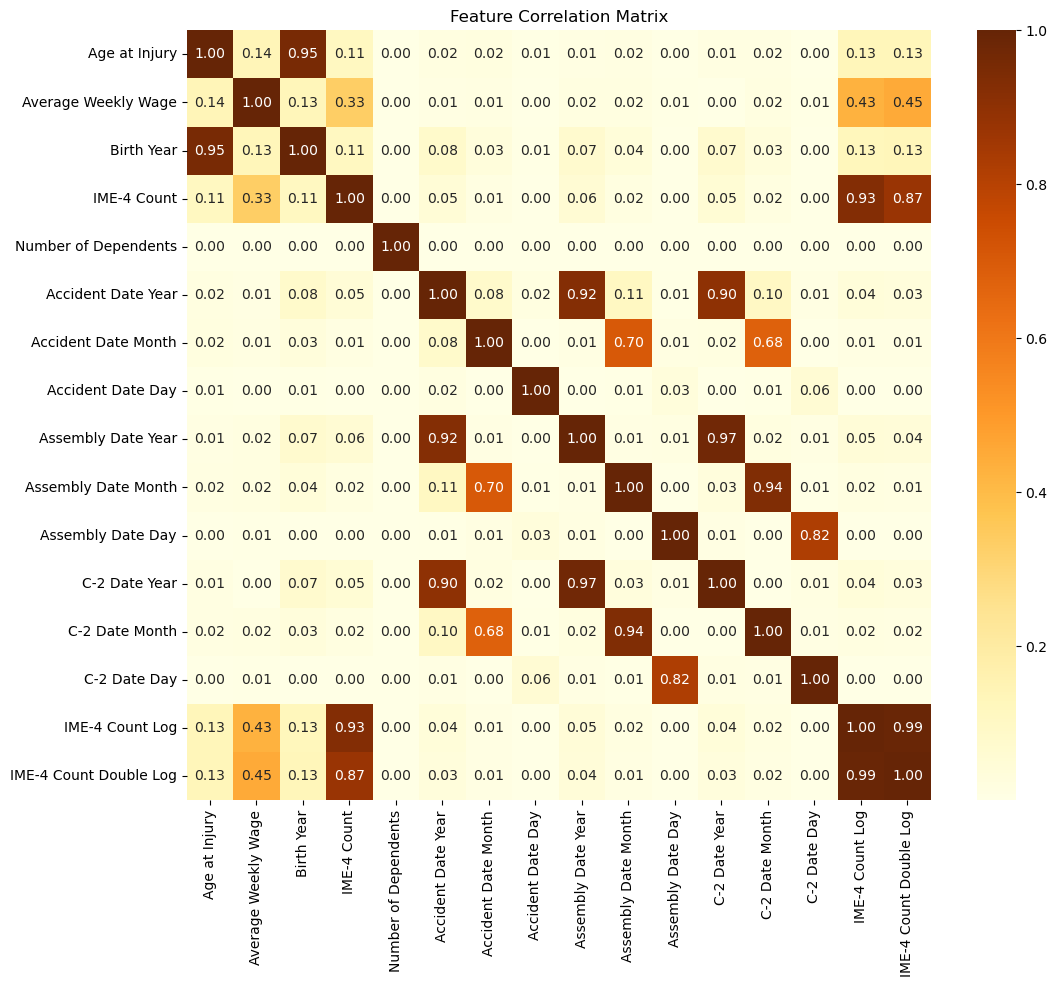

In [ ]:
# Visualize the correlation matrix to identify relationships between numerical features
fs.correlation_matrix(X_train[num])

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def chi_squared(X_categ, y, threshold=0.05):

    # Fit the chi-squared selector
    chi2_selector = SelectKBest(chi2, k='all')
    chi2_selector.fit(X_categ, y)

    # Get Chi-squared scores and p-values
    chi2_scores = chi2_selector.scores_
    p_values = chi2_selector.pvalues_

    # Create a DataFrame for scores and p-values
    scores_df = pd.DataFrame({
        'Feature': X_categ.columns,
        'Chi2 Score': chi2_scores,
        'p-value': p_values
    })

    # Filter features based on the p-value threshold
    selected_features = scores_df[scores_df['p-value'] < threshold]['Feature']
    
    # Extract non-selected features
    non_selected_features = scores_df[scores_df['p-value'] >= threshold]

    # Plot the Chi-squared scores
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Chi2 Score', y='Feature', data=scores_df.sort_values(by='Chi2 Score', ascending=False), color='orange')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'p-value Threshold = {threshold}')
    plt.title('Chi-squared Scores for Features')
    plt.xlabel('Chi-squared Score')
    plt.ylabel('Features')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nInitial Features: {len(X_categ.columns.tolist())}\n")
    print(X_categ.columns.tolist())
    print(f"\nDecision for Categorical Features (p-value < threshold): {len(selected_features.tolist())}\n")
    print(selected_features.tolist())

    # Display non-selected features with their p-values and Chi-squared scores
    print("\nNon-Selected Features (p-value >= threshold):\n")
    print(non_selected_features[['Feature', 'Chi2 Score', 'p-value']])


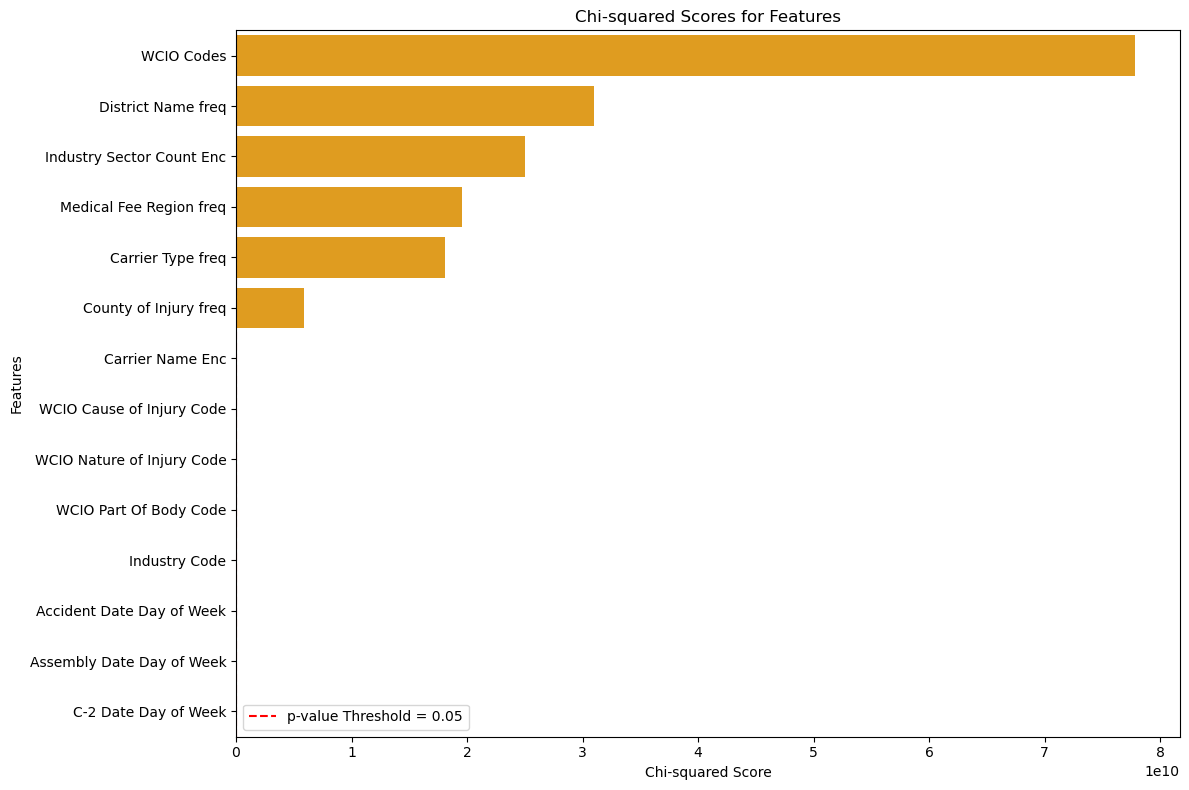


Initial Features: 14

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc']

Decision for Categorical Features (p-value < threshold): 14

['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Carrier Name Enc', 'Carrier Type freq', 'County of Injury freq', 'District Name freq', 'Medical Fee Region freq', 'Accident Date Day of Week', 'Assembly Date Day of Week', 'C-2 Date Day of Week', 'WCIO Codes', 'Industry Sector Count Enc']

Non-Selected Features (p-value >= threshold):

Empty DataFrame
Columns: [Feature, Chi2 Score, p-value]
Index: []


In [ ]:
chi_squared(X_train[categ], y_train)

## 4.2 Wrapper Methods

<a href="#top">Top &#129033;</a>

Unlike filter methods, which assess features independently, wrapper methods evaluate the effectiveness of feature subsets by measuring the model’s performance, making them more computationally expensive but often more accurate in selecting relevant features.

## 4.3 Embedded Methods

<a href="#top">Top &#129033;</a>

These methods use algorithms that inherently select features as part of the model’s learning process. Embedded methods are computationally efficient and tend to be more accurate than filter methods, as they consider feature interactions and model performance simultaneously.
